In [2]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parameters
Modelde kullanılacak parametreler burada tanımlanıyor. 
image_size: Resimlerin boyutlarını standartlaştırmak için kullanılır.
num_classes: Sınıflandırılacak hayvan sınıflarının sayısı.
batch_size: Her iterasyonda modele verilecek veri miktarı.
epochs: Modelin tüm veri seti üzerinde kaç defa eğitim yapılacağını belirtir.

In [3]:

# Parameters
image_size = (128, 128)  # Resize all images to 128x128
num_classes = 10  # Number of classes for classification
batch_size = 32
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset location and target classes
Veri setinin yolu ve sınıflandırılacak hayvan sınıfları burada tanımlanmıştır.
Kaggle'dan alınan veri seti yolunda belirtilen JPEGImages klasörü kullanılacaktır.

In [4]:
# Dataset location and target classes
data_path = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
target_classes = ['collie', 'dolphin', 'elephant', 'fox', 'moose', 'rabbit', 'sheep', 'squirrel', 'giant panda', 'polar bear']


# Load data function
Bu fonksiyon veri setini yüklemek, yeniden boyutlandırmak ve normalize etmek için kullanılır.
Resimlerin normalize edilmesi, modelin daha iyi performans göstermesini sağlar.

In [5]:

# Load data function
def load_data(data_path, target_classes, image_size, class_image_limit):
    images = []
    labels = []
    for class_index, class_name in enumerate(target_classes):
        class_path = os.path.join(data_path, class_name)
        if not os.path.exists(class_path):
            continue

        files = os.listdir(class_path)[:class_image_limit]
        for file in files:
            image_path = os.path.join(class_path, file)
            image = cv2.imread(image_path)
            if image is not None:
                resized_image = cv2.resize(image, image_size)
                images.append(resized_image)
                labels.append(class_index)

    images = np.array(images, dtype=np.float32) / 255.0  # Normalize
    labels = np.array(labels, dtype=np.int64)
    return images, labels

# Custom PyTorch Dataset class
PyTorch Dataset sınıfı, veri setinin modellenmesi ve dönüşümlerin uygulanması için tanımlanmıştır.
Bu sınıf, veri setini kolayca işlemek ve modele uygun hale getirmek için kullanılır.

In [6]:

# Custom PyTorch Dataset class
class AnimalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Visualization function
Örnek görüntülerin görselleştirilmesi için bu fonksiyon kullanılır.
Görüntülerin doğru yüklendiğini ve sınıfların doğru etiketlendiğini kontrol etmek için faydalıdır.

In [27]:

# Visualization function
def visualize_images(title, images, labels, target_classes, count=5):
    plt.figure(figsize=(15, 5))
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(images[i])
        plt.title(target_classes[labels[i]])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Gray World algorithm for color constancy
Gray World algoritması, renk sabitliği sağlamak için kullanılır.
Görüntülerin aydınlatma koşullarından bağımsız olarak dengelenmesini amaçlar.

In [8]:

# Gray World algorithm for color constancy
def apply_gray_world(images):
    corrected_images = []
    for image in images:
        img_gray = np.mean(image, axis=(0, 1))
        scale = np.mean(img_gray) / img_gray
        corrected_image = np.clip(image * scale, 0, 1)
        corrected_images.append(corrected_image)
    return np.array(corrected_images, dtype=np.float32)


# Load dataset
Veri seti yükleniyor ve görselleştirme ile örnek görüntüler kontrol ediliyor.

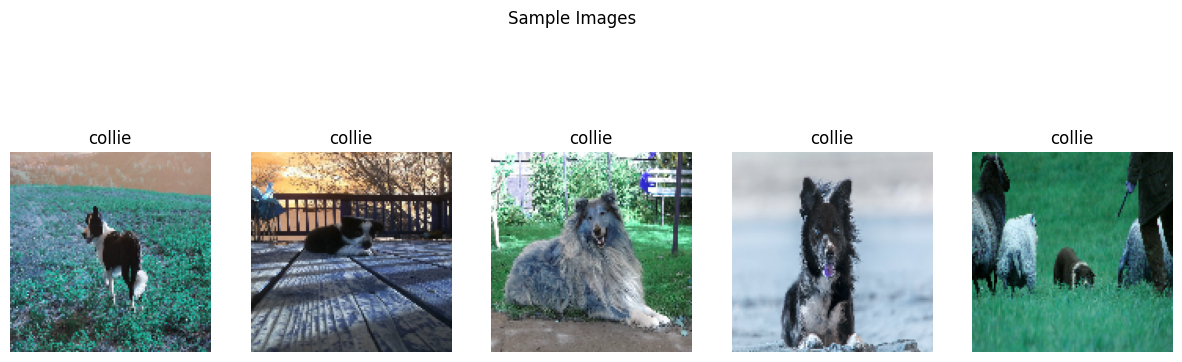

In [9]:

# Load dataset
class_image_limit = 650  # Limit number of images per class
images, labels = load_data(data_path, target_classes, image_size, class_image_limit)
visualize_images("Sample Images", images, labels, target_classes)

# Split dataset into train and test sets
Veri seti eğitim ve test olarak ayrılıyor.
random_state kullanılarak her çalıştırmada aynı sonuçların alınması sağlanıyor.

In [10]:

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

In [12]:
len(X_train)

3640


# Transformations
Eğitim seti için veri artırma teknikleri uygulanıyor.
Test setinde sadece normalize işlemi yapılıyor.

In [13]:
# Transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Derin CNN Modeli Tanımı
Aşağıda, bir derin Konvolüsyonel Sinir Ağı (CNN) modelinin PyTorch kullanılarak nasıl tanımlandığını gösteren kod bulunmaktadır. Bu model, görsellerin sınıflandırılmasında kullanılacak ve üç ana bölüme ayrılmıştır: özellik çıkarıcı (feature extractor), tam bağlantılı sınıflandırıcı (fully connected classifier) ve öğrenme işlemi.

1. Özellik Çıkarıcı Bölüm (Feature Extractor)
Modelin ilk kısmı, birkaç konvolüsyonel katman (Conv2d) ve aktifleşme (ReLU) fonksiyonları içerir. Bu katmanlar, görüntülerden özellikleri çıkarır. Konvolüsyonel katmanların her biri bir filtreyi (kernel) kullanarak giriş görüntüsünün çeşitli özelliklerini öğrenir. Ardından, bu özellikler max pooling katmanları ile özetlenir.

2. Sınıflandırıcı Bölüm (Classifier)
Modelin ikinci kısmı ise çıkarılan özellikleri kullanarak sınıflandırma yapacak olan tam bağlantılı katmanlardan oluşur. Bu bölümde:

Lineer katmanlar (Linear) ile sınıflandırma yapılır.
ReLU aktivasyon fonksiyonu, modelin doğrusal olmayan ilişkileri öğrenmesini sağlar.
Dropout katmanları, aşırı öğrenmeyi engellemek amacıyla kullanılan düzenlendirici katmanlardır.

3. İleri Yönlü İletim (Forward Pass)
Modelin ileri yönlü iletimi, görüntülerin sırasıyla konvolüsyonel katmanlar ve tam bağlantılı katmanlar üzerinden geçirilmesiyle yapılır. Sonuçta, sınıflandırma için tahmin edilen değerler çıkacaktır.


In [15]:
# Define a deeper CNN model
class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 16 * 16, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Verilerin Hazırlanması ve Model Eğitimi için Veri Yükleyicisi (DataLoader) ve Eğitim Ayarları
Aşağıda, verilerin yüklenmesi, modelin eğitilmesi için gerekli ayarlamaların yapılması ve eğitim sürecinde kullanılan optimizer, kayıp fonksiyonu (loss function), ve öğrenme oranı planlayıcısının (learning rate scheduler) nasıl tanımlandığını anlatan kod örneği bulunmaktadır.
Veri Yükleyicileri (DataLoader) Hazırlığı
Modelin eğitimi için verilerin uygun şekilde yüklenmesi gereklidir. train_loader ve val_loader, eğitim ve doğrulama verilerini toplamak ve bunları modelin girişine sağlamak için kullanılır. Veriler, kullanıcı tarafından tanımlanan AnimalDataset sınıfı ile yüklenir ve her iki veri kümesi için uygun dönüşümler (train_transform ve val_transform) uygulanır.

In [16]:

# Prepare DataLoader
train_dataset = AnimalDataset(X_train, y_train, transform=train_transform)
val_dataset = AnimalDataset(X_test, y_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create model, criterion, optimizer, and scheduler
model = DeeperCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


2. Model, Kayıp Fonksiyonu (Loss Function), Optimizatör ve Öğrenme Oranı Planlayıcısı (Scheduler) Tanımlamaları
Modelin eğitilmesi için gerekli olan bileşenler tanımlanır. Burada, kullanılan optimizatör olarak Adam ve kayıp fonksiyonu olarak CrossEntropyLoss seçilmiştir. Ayrıca, öğrenme oranını dinamik olarak ayarlamak için StepLR öğrenme oranı planlayıcısı kullanılır.
  
* Adam optimizatörü, modelin öğrenme sürecinde ağırlıkları güncellemek için kullanılan bir algoritmadır ve genellikle çok iyi sonuçlar verir.
* CrossEntropyLoss: Çok sınıflı sınıflandırma problemleri için yaygın olarak kullanılan kayıp fonksiyonudur.
* StepLR: Öğrenme oranını belirli aralıklarla (örneğin her 10 epokta bir) azaltır, bu da modelin daha stabil öğrenmesini sağlayabi  


# Eğitim ve Doğrulama Döngüsü
1. Eğitim ve Doğrulama Fonksiyonu
train_and_validate fonksiyonu, modelin her epoch'ta nasıl eğitileceğini ve doğrulama işleminin nasıl yapılacağını belirler. Ayrıca, doğrulama doğruluğunun en iyisini takip eder.

  * Eğitim Aşaması: Model eğitim moduna alındığında, her batch'te kayıp hesaplanır ve optimizer ile ağırlıklar güncellenir. Epoch tamamlandığında ortalama kayıp (loss) yazdırılır.
  * Doğrulama Aşaması: Model, doğrulama moduna alındığında, doğrulama veri kümesinde doğruluk hesaplanır. Doğruluk, doğru tahminlerin toplamının veri kümesindeki toplam örnek sayısına bölünmesiyle elde edilir.
  * En İyi Doğruluk: Modelin en iyi doğruluğu, her epoch sonunda güncellenir.

2. Eğitim ve Doğrulama İşlemi Başlatma
Eğitim ve doğrulama işlemi başlatıldığında, train_and_validate fonksiyonu çağrılır. Sonrasında, en iyi doğruluk değeri yazdırılır.
  * Bu kod, en iyi doğruluğu döndürür ve sonunda konsolda yazdırır.

In [18]:

# Training and validation loop
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler):
    best_accuracy = 0.0
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

        # Validation phase
        model.eval()
        val_accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_accuracy += torch.sum(preds == targets.data).item()

        val_accuracy /= len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        best_accuracy = max(best_accuracy, val_accuracy)

    return best_accuracy

# Train and validate
best_accuracy = train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Epoch 1/30, Loss: 2.1425
Validation Accuracy: 0.2051
Epoch 2/30, Loss: 1.9138
Validation Accuracy: 0.2590
Epoch 3/30, Loss: 1.8792
Validation Accuracy: 0.2692
Epoch 4/30, Loss: 1.8524
Validation Accuracy: 0.2410
Epoch 5/30, Loss: 1.8442
Validation Accuracy: 0.2897
Epoch 6/30, Loss: 1.8315
Validation Accuracy: 0.3115
Epoch 7/30, Loss: 1.8228
Validation Accuracy: 0.3096
Epoch 8/30, Loss: 1.8186
Validation Accuracy: 0.3154
Epoch 9/30, Loss: 1.7981
Validation Accuracy: 0.3237
Epoch 10/30, Loss: 1.7824
Validation Accuracy: 0.3385
Epoch 11/30, Loss: 1.7553
Validation Accuracy: 0.3994
Epoch 12/30, Loss: 1.7247
Validation Accuracy: 0.4353
Epoch 13/30, Loss: 1.6885
Validation Accuracy: 0.4500
Epoch 14/30, Loss: 1.6398
Validation Accuracy: 0.4795
Epoch 15/30, Loss: 1.6019
Validation Accuracy: 0.4853
Epoch 16/30, Loss: 1.5886
Validation Accuracy: 0.5288
Epoch 17/30, Loss: 1.5435
Validation Accuracy: 0.5288
Epoch 18/30, Loss: 1.5351
Validation Accuracy: 0.5474
Epoch 19/30, Loss: 1.4900
Validation 

# Görüntü Manipülasyonu:

İlk olarak, her bir görüntüdeki pixel değerleri 1.2 ile çarpılarak parlaklık artırılır.

**Görüntü Düzeltme:**
Manipüle edilmiş görüntüler üzerinde apply_gray_world fonksiyonuyla renk dengelemesi (grayscale correction) yapılır.

**Yeni Veri Kümeleri Oluşturma:**
Manipüle edilmiş ve düzeltme yapılmış görüntülerle yeni veri kümeleri oluşturulur. Her iki veri kümesinde de etiketler aynıdır.

**Veri Yükleyicileri (DataLoader):**
Manipüle edilmiş ve düzeltme yapılmış veri kümeleri, modelin eğitim veya doğrulama aşamasında kullanılmak üzere veri yükleyicilerine aktarılır.

In [19]:

manipulated_images = images * 1.2  # Example manipulation
corrected_images = apply_gray_world(manipulated_images)

manipulated_dataset = AnimalDataset(manipulated_images, labels, transform=val_transform)
corrected_dataset = AnimalDataset(corrected_images, labels, transform=val_transform)

manipulated_loader = DataLoader(manipulated_dataset, batch_size=batch_size, shuffle=False)
corrected_loader = DataLoader(corrected_dataset, batch_size=batch_size, shuffle=False)


# Görselleştirme: Manipüle Edilmiş ve Düzeltme Yapılmış Görüntüler
Bu bölümde, manipüle edilmiş ve düzeltme yapılmış görüntülerin yan yana görselleştirilmesi için bir fonksiyon tanımlanır. Fonksiyon, her iki görüntü kümesinin (manipüle edilmiş ve düzeltme yapılmış) örneklerini görsel olarak sunar.

**Manipüle Edilmiş Görüntüler:**
İlk olarak, manipüle edilmiş görüntüler görselleştirilir.

**Düzeltme Yapılmış Görüntüler:**
Ardından, gri dünya düzeltmesi (color correction) yapılmış görüntüler görselleştirilir.

**Yan Yana Görselleştirme:**
Her iki görüntü türü, matplotlib kullanılarak yan yana yerleştirilir ve her bir örneğin sınıf etiketi de başlık olarak eklenir.

<ipython-input-20-c8b74e1a9cc6>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, count, i + 1)
<ipython-input-20-c8b74e1a9cc6>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)
<ipython-input-20-c8b74e1a9cc6>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, count, i + 1)


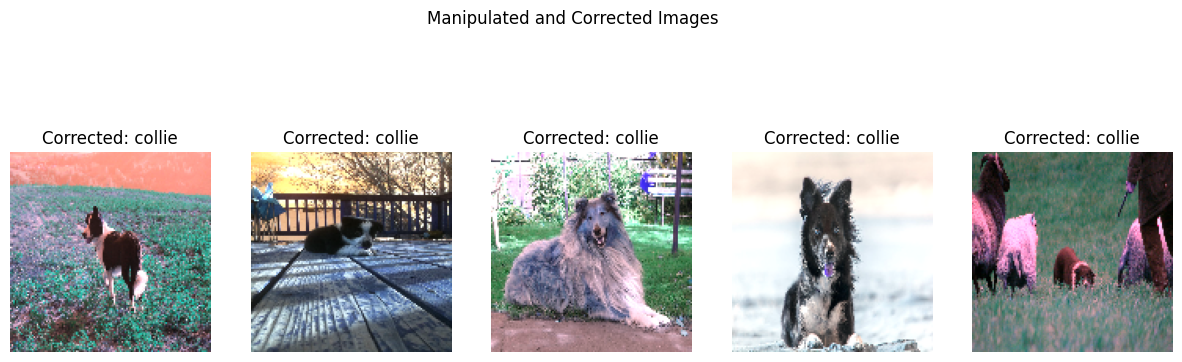

In [20]:
def visualize_manipulated_images(manipulated_images, corrected_images, labels, target_classes, count=5):
    plt.figure(figsize=(15, 5))
    
    # Manipüle edilmiş görüntüler
    plt.subplot(1, 2, 1)
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(manipulated_images[i])
        plt.title(f"Manipulated: {target_classes[labels[i]]}")
        plt.axis('off')
    
    # Renk düzeltmesi yapılmış görüntüler
    plt.subplot(1, 2, 2)
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(corrected_images[i])
        plt.title(f"Corrected: {target_classes[labels[i]]}")
        plt.axis('off')
    
    plt.suptitle("Manipulated and Corrected Images")
    plt.show()

# Görselleştirme işlemi
visualize_manipulated_images(manipulated_images, corrected_images, labels, target_classes)

# Model Değerlendirme

**Model Değerlendirme:**
Model, değerlendirme modunda çalıştırılır (model.eval()).
Değerlendirme fonksiyonu, her bir veri kümesi üzerinde modelin tahminlerini alır ve doğruluğu hesaplar.

**Doğruluk Hesaplama:**
Her bir veri kümesi için (orijinal, manipüle edilmiş ve düzeltme yapılmış) doğruluk değeri hesaplanır.

In [21]:
# Evaluate model
# Modelin farklı veri setleri üzerindeki doğruluk değerleri hesaplanır.
model.eval()
def evaluate(loader):
    accuracy = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            accuracy += torch.sum(preds == targets.data).item()
    return accuracy / len(loader.dataset)

original_accuracy = evaluate(val_loader)
manipulated_accuracy = evaluate(manipulated_loader)
corrected_accuracy = evaluate(corrected_loader)


# Test Seti Sonuçlarının Görselleştirilmesi

**Doğruluk Karşılaştırması:**
* Orijinal test seti, manipüle edilmiş test seti ve düzeltme yapılmış test seti için elde edilen doğruluk değerleri karşılaştırılır.
* Sonuçlar bir çubuk grafikle görselleştirilir.

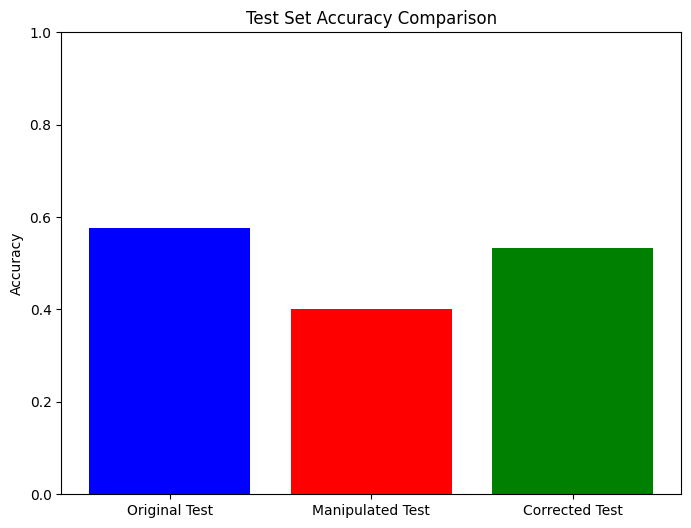

In [22]:
# Visualize test set results
labels = ['Original Test', 'Manipulated Test', 'Corrected Test']
accuracies = [original_accuracy, manipulated_accuracy, corrected_accuracy]
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'red', 'green'])
plt.ylabel('Accuracy')
plt.title('Test Set Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


# Doğruluk Sonuçlarının Yazdırılması
Modelin orijinal, manipüle edilmiş ve düzeltme yapılmış test setleri üzerindeki doğruluk değerleri yazdırılır.

In [23]:

print(f"Original Test Accuracy: {original_accuracy:.4f}")
print(f"Manipulated Test Accuracy: {manipulated_accuracy:.4f}")
print(f"Corrected Test Accuracy: {corrected_accuracy:.4f}")

Original Test Accuracy: 0.5769
Manipulated Test Accuracy: 0.4021
Corrected Test Accuracy: 0.5327
